In [4]:
suppressMessages(library("rwwa"))

nsamp <- 1000
mdl_args <- list(dist = "norm", type = "shift")

# GMST only

## Trend estimation

In [5]:
rp <- 10

for (fnm in list.files("ts", pattern = "pi_cmip6", full.names = T)) {
    print(fnm)

    gcm <- gsub(".+cmip6_|.dat","",fnm)
                
    res_fnm <- gsub("ts/.+cmip6_", "res/res-cmip6_gmstonly_pi_", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
     
    gmst_fnm <- list.files("~/00_WWA_project_folder/live/data/cmip6-gmsts/2024/ssp585/", pattern = gcm, full.names = T)[1]
    if(length(gmst_fnm) == 0) next
    
    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    df <- merge(gmst, ts)
    df <- df[df$year <= 2070,]
    
    df$x <- as.numeric(df$x)
    df <- df[!is.na(df$x),]
    if (nrow(df) < 75) { next }

    # pick up model to be fitted depending on variable
    mdl <- tryCatch({
            do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = "gmst", lower = F)))
        }, error = function(cond) {
            return(NULL)
        })
    if (is.null(mdl)) { 
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = "gmst", lower = F, "method" = "Nelder-Mead")))
    }

    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                          y_now = 2025, y_start = 1950, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/res", "mdl-eval/rlplot", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub("dat", "", fnm)))
        }; dev.off()
    }
}

[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-CM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-ESM1-5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_BCC-CSM2-MR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CAMS-CSM1-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5-CanOE_r1i1p2f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-CM2-SR5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-ESM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_E3SM-1-1_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_HadGEM3-GC31-LL_r1i1p1f3.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM4-8_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM5-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KACE-1-0-G_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KIOST-ESM_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MIROC6_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MPI-ESM1-2-LR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_

## Compile

In [13]:
mdl_res <- t(sapply(list.files("res", pattern = "cmip6_gmstonly", full.names = T), read.csv))
rownames(mdl_res) <- gsub(".+cmip6_|.csv","",rownames(mdl_res))
write.csv(mdl_res, "res-models_pi_gmst-only.csv")

## Synthesis

In [57]:
res_mdl <- read.csv("res-models_pi_gmst-only.csv", row.names = "X.1")
res_obs <- read.csv("res/res-obs_gmstonly_pi_era5.csv", row.names = "X")

include <- read.csv("model-eval_gmst+amo.csv")
res_mdl <- res_mdl[include$model[include$include == "Y"],]

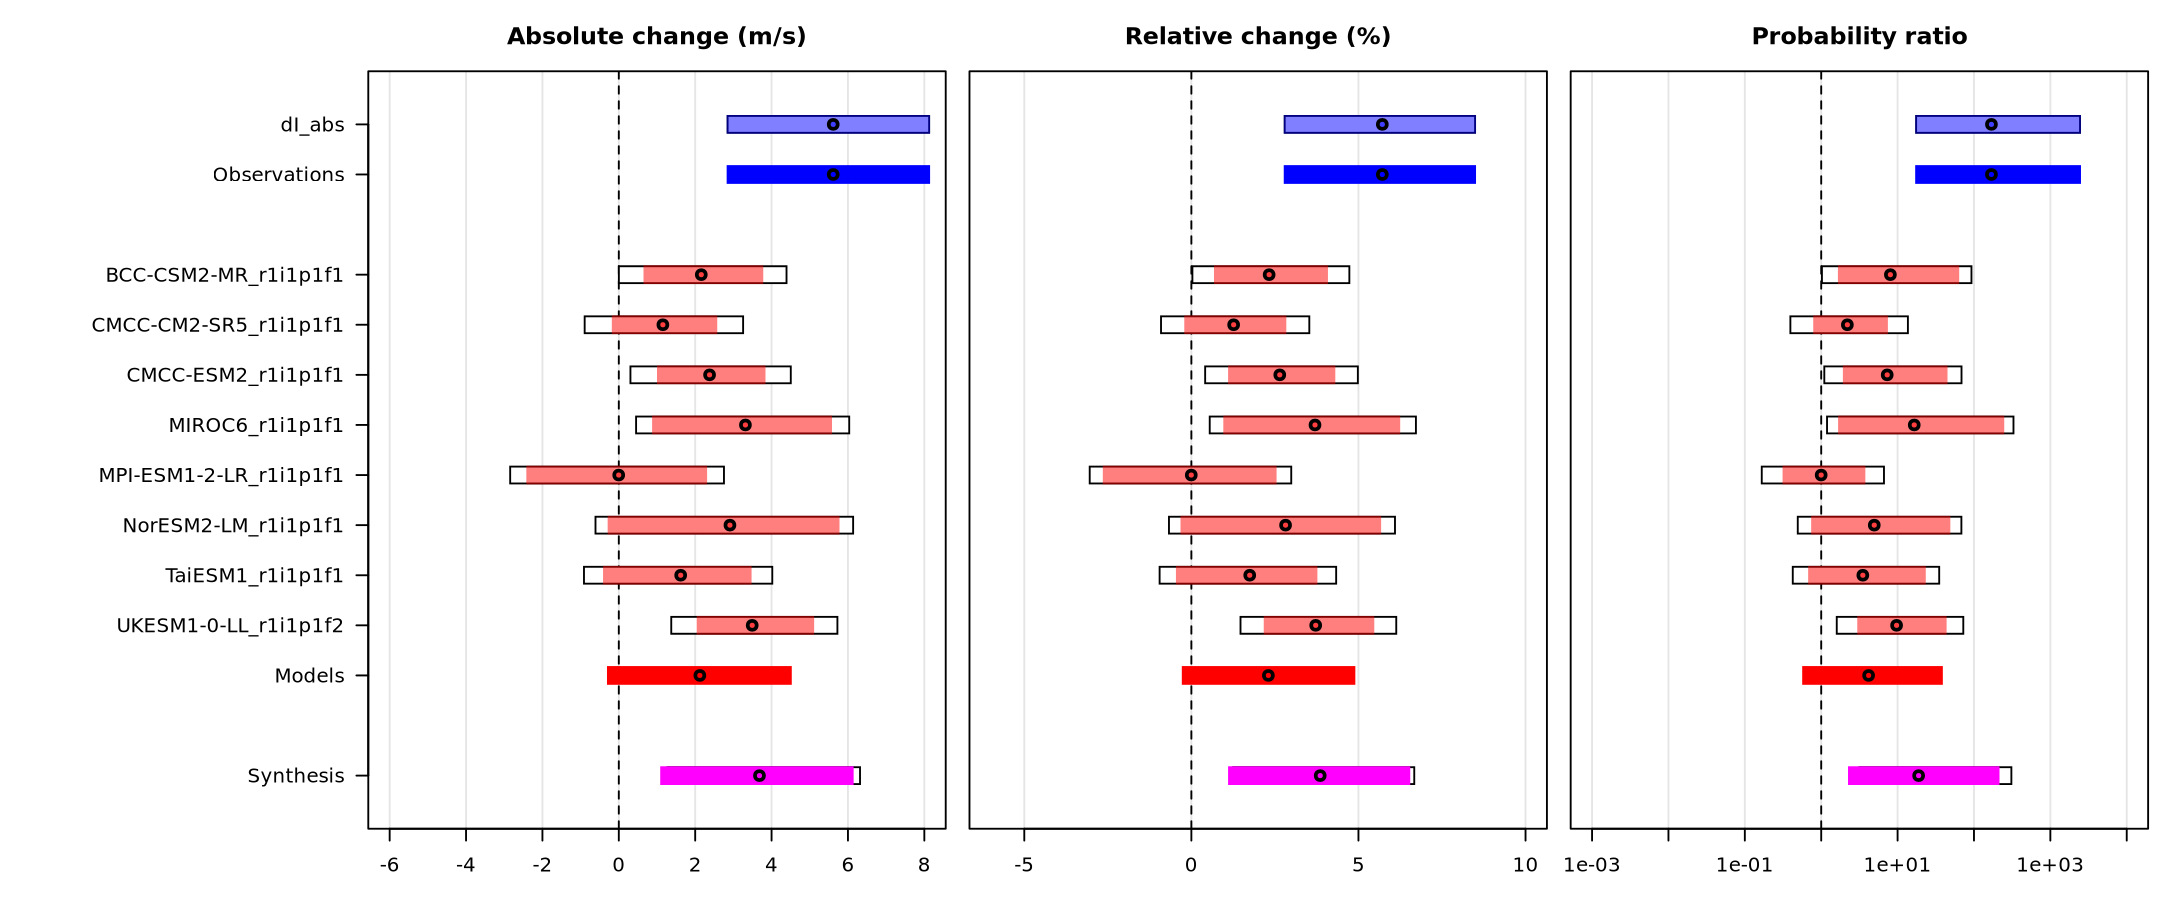

In [58]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synthesis(obs_in = res_obs["dI_abs",],
                         models_in = res_mdl[,grepl("attr_dI.abs",colnames(res_mdl))],
                         synth_type = "abs"), hide_labels = F, main = "Absolute change (m/s)", xlim = c(-6,8))

plot_synthesis(synthesis(obs_in = res_obs["dI_rel",],
                         models_in = res_mdl[,grepl("attr_dI.rel",colnames(res_mdl))],
                         synth_type = "rel"), hide_labels = T, main = "Relative change (%)", xlim = c(-6,10))

plot_synthesis(synthesis(obs_in = res_obs["PR",],
                         models_in = res_mdl[,grepl("attr_PR",colnames(res_mdl))],
                         synth_type = "PR"), hide_labels = T, main = "Probability ratio", xlim = c(1e-3, 1e4))

In [33]:
round(read.csv("res/res-obs_gmst+amo_pi_era5.csv", row.names = "X"), 0)#[-c(11),]

,est,X2.5.,X97.5.
,<dbl>,<dbl>,<dbl>
mu0,8.300000e+01,7.800000e+01,8.700000e+01
sigma0,2.000000e+00,2.000000e+00,3.000000e+00
alpha_gmst,3.000000e+00,1.000000e+00,4.000000e+00
alpha_amo_sm10,1.500000e+01,1.100000e+01,1.900000e+01
disp,0.000000e+00,0.000000e+00,0.000000e+00
event_magnitude,1.040000e+02,1.040000e+02,1.040000e+02
return_period,4.000000e+00,2.000000e+00,1.800000e+01
PR_pi,2.300000e+01,4.000000e+00,2.040000e+02
dI_abs_pi,4.000000e+00,2.000000e+00,6.000000e+00


# GMST + AMO

## Trend estimation

In [2]:
rp <- 5
for (fnm in list.files("ts", pattern = "pi_cmip6", full.names = T)) {
    print(fnm)

    gcm <- gsub(".+cmip6_|.dat","",fnm)
                
    res_fnm <- gsub("ts/.+cmip6_", "res/res-cmip6_gmst+amo_pi_", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
     
    gmst_fnm <- list.files("~/00_WWA_project_folder/live/data/cmip6-gmsts/2024/ssp585/", pattern = gcm, full.names = T)
    if(length(gmst_fnm) == 0) next

    amo_fnm <- list.files("ts", pattern = paste0("amo.+", gcm), full.names = T)
    if(length(amo_fnm) == 0) next

    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    amo <- load_ts(amo_fnm, col.names = c("year", "amo"))
    df <- merge(merge(gmst, amo), ts)
    df <- df[df$year <= 2070,]
    
    df$x <- as.numeric(df$x)
    df <- df[!is.na(df$x),]
    if (nrow(df) < 75) { next }

    # pick up model to be fitted depending on variable
    mdl <- tryCatch({
            do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "amo"), lower = F)))
        }, error = function(cond) {
            return(NULL)
        })
    if (is.null(mdl)) { 
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "amo"), lower = F, "method" = "Nelder-Mead")))
    }

    # use model's 2025 GMST to define factual climate
    cov_now <- df[df$year == 2025,c("gmst", "amo"),drop = F]
    cov_hist <- cov_now - c(1.3, 0)
    cov_fut <- cov_now + c(1.3, 0)

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                          y_now = 2025, y_start = 1950, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/res", "mdl-eval/rlplot", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub("dat", "", fnm)), legend_pos = "bottomright")
        }; dev.off()
    }
}

[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-CM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-ESM1-5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_BCC-CSM2-MR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CAMS-CSM1-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5-CanOE_r1i1p2f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-CM2-SR5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-ESM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_E3SM-1-1_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_HadGEM3-GC31-LL_r1i1p1f3.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM4-8_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM5-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KACE-1-0-G_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KIOST-ESM_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MIROC6_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MPI-ESM1-2-LR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_

## Bootstrap correlation between AMO & PI

In [17]:
for (fnm in list.files("ts", pattern = "pi_cmip6", full.names = T)) {
    print(fnm)

    gcm <- gsub(".+cmip6_|.dat","",fnm)
                
    corr_fnm <- gsub("ts/.+cmip6_", "res/corr-cmip6_amo-pi_", gsub(".dat", ".csv", fnm))
    if (file.exists(corr_fnm)) next
     
    gmst_fnm <- list.files("~/00_WWA_project_folder/live/data/cmip6-gmsts/2024/ssp585/", pattern = gcm, full.names = T)
    if(length(gmst_fnm) == 0) next

    amo_fnm <- list.files("ts", pattern = paste0("amo.+", gcm), full.names = T)
    if(length(amo_fnm) == 0) next

    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    amo <- load_ts(amo_fnm, col.names = c("year", "amo"))
    df <- merge(merge(gmst, amo), ts)
    df <- df[df$year <= 2070,]
    
    df$x <- as.numeric(df$x)
    df <- df[!is.na(df$x),]
    if (nrow(df) < 75) { next }

    set.seed(42)
    z <- sapply(1:1000, function(i) {
        boot_df <- df[sample(1:nrow(df), replace = T), ]
        c("amo_sd" = sd(boot_df$amo), "amo_corr" = cor(boot_df$amo, boot_df$x))
    })
    
    boot_ests <- t(rbind("est" = c("amo_sd" = sd(df$amo), "amo_corr" = cor(df$amo, df$x)),
                       apply(z, 1, quantile, c(0.025, 0.975))))
    boot_ests <- unlist(lapply(rownames(boot_ests), function(cnm) setNames(boot_ests[cnm, ], paste(gsub("_", "-", cnm), 
                                                                                  c("est", "lower", "upper"), sep = "_"))))
    write.csv(t(boot_ests), corr_fnm, row.names = F)
}

[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-CM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-ESM1-5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_BCC-CSM2-MR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CAMS-CSM1-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5-CanOE_r1i1p2f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-CM2-SR5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-ESM2_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_E3SM-1-1_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_HadGEM3-GC31-LL_r1i1p1f3.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM4-8_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_INM-CM5-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KACE-1-0-G_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_KIOST-ESM_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MIROC6_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_MPI-ESM1-2-LR_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_

## Compile results

In [18]:
mdl_res <- rbind.fill(sapply(fl, function(fnm) {

    res <- read.csv(fnm)
    gcm <- gsub(".+pi_|.csv","",fnm)
    
    corr_fnm <- list.files("res", pattern = paste0("corr-cmip6.+",gcm), full.names = T)
    if (length(corr_fnm) == 0) {
        res_cor <- setNames(rep(NA, 6),
                             c('amo.sd_est','amo.sd_lower','amo.sd_upper','amo.corr_est','amo.corr_lower','amo.corr_upper'))
    } else {
        res_cor <- read.csv(corr_fnm)
    }
    cbind(res, res_cor)
}, simplify = F))
rownames(mdl_res) <- gsub(".+pi_|.csv","",fl)
write.csv(mdl_res, "res-models_pi_gmst+amo.csv")

## Compare parameter ests

In [20]:
res_mdl <- read.csv("res-models_pi_gmst+amo.csv", row.names = "X.1")
res_obs <- rbind(read.csv("res/res-obs_gmst+amo_pi_era5.csv", row.names = "X"),
                 read.csv("res/corr-obs_gmst+amo_pi_era5.csv", row.names = "X"))

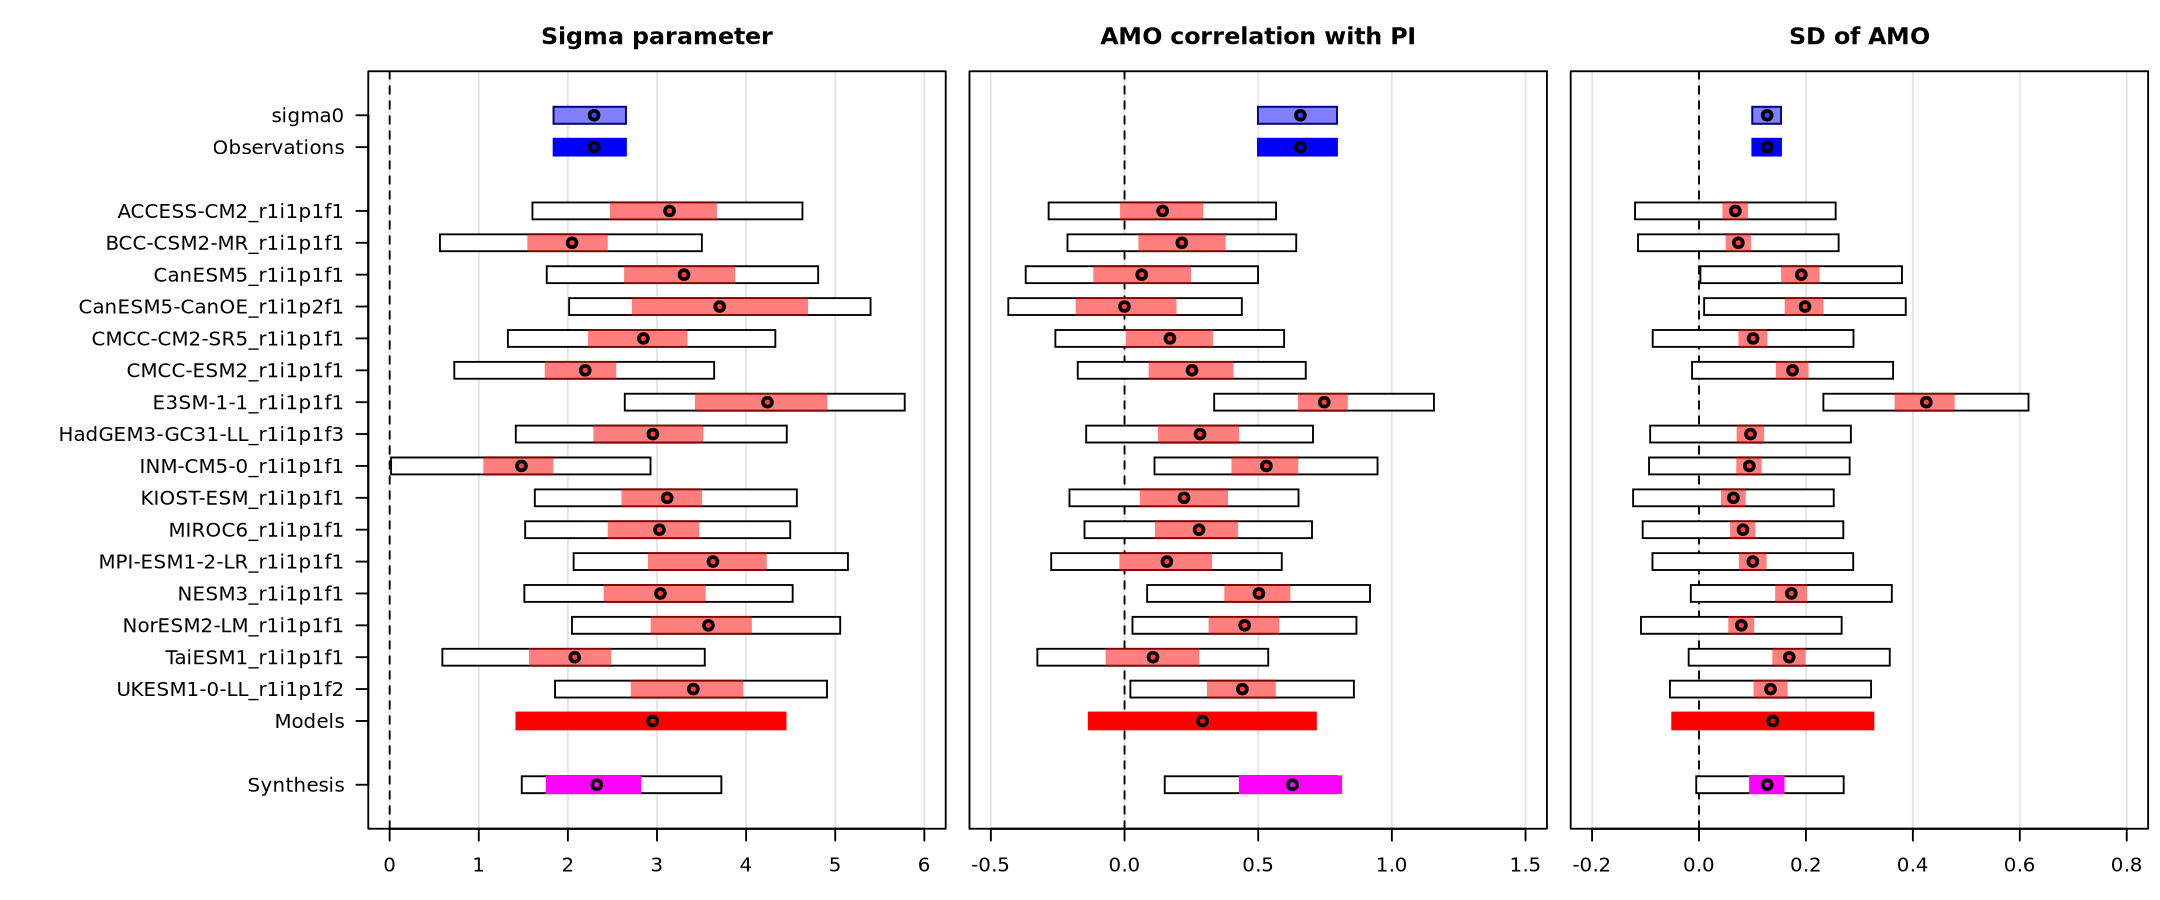

In [21]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synthesis(obs_in = res_obs["sigma0",,drop = F],
                         models_in = res_mdl[,grepl("eval_sigma0",colnames(res_mdl))], 
                         synth_type = "abs"),
              main = "Sigma parameter", hide_labels = F)

plot_synthesis(synthesis(obs_in = res_obs["amo_corr",,drop = F],
                         models_in = res_mdl[,grepl("amo.corr",colnames(res_mdl))], 
                         synth_type = "abs"),
              main = "AMO correlation with PI", hide_labels = T)

plot_synthesis(synthesis(obs_in = res_obs["amo_sd",,drop = F],
                         models_in = res_mdl[,grepl("amo.sd",colnames(res_mdl))], 
                         synth_type = "abs"),
              main = "SD of AMO", hide_labels = T)


## Synthesis

In [2]:
res_mdl <- read.csv("res-models_pi_gmst+amo.csv", row.names = "X.1")
res_obs <- read.csv("res/res-obs_gmst+amo_pi_era5.csv", row.names = "X")

include <- read.csv("model-eval_gmst+amo.csv")
res_mdl <- res_mdl[include$model[include$include == "Y"],]

In [3]:
synth_attr_abs <- synthesis(obs_in = res_obs["dI_abs_pi",],
                            models_in = res_mdl[,grepl("attr_dI.abs",colnames(res_mdl))],
                            synth_type = "abs")

synth_attr_rel <- synthesis(obs_in = res_obs["dI_rel_pi",],
                            models_in = res_mdl[,grepl("attr_dI.rel",colnames(res_mdl))],
                            synth_type = "rel")

synth_attr_pr <- synthesis(obs_in = res_obs["PR_pi",],
                           models_in = res_mdl[,grepl("attr_PR",colnames(res_mdl))],
                           synth_type = "PR")

synth_proj_abs <- synthesis(obs_in = NA,
                            models_in = res_mdl[,grepl("proj_dI.abs",colnames(res_mdl))],
                            synth_type = "abs")

synth_proj_rel <- synthesis(obs_in = NA,
                            models_in = res_mdl[,grepl("proj_dI.rel",colnames(res_mdl))],
                            synth_type = "rel")

synth_proj_pr <- synthesis(obs_in = NA,
                           models_in = res_mdl[,grepl("proj_PR",colnames(res_mdl))],
                           synth_type = "PR")

In [4]:
for (synth_period in c("attr", "proj")) {
    for (synth_type in c("abs", "rel", "pr")) {
        synth <- get(paste0("synth_",synth_period,"_",synth_type))
        if (synth_period == "attr") { synth$df[1,2] <- "ERA5"}
        write.csv(rbind(synth$df,
                        setNames(c("unweighted", "Unweighted", synth$uw_mean, synth$df[nrow(synth$df),6:7], NA, NA),
                                 colnames(synth$df))),
                  paste0("synth/synth-pi_gmst+amo_gmst-effect_",synth_period,"_",synth_type,".csv"))
    }
}

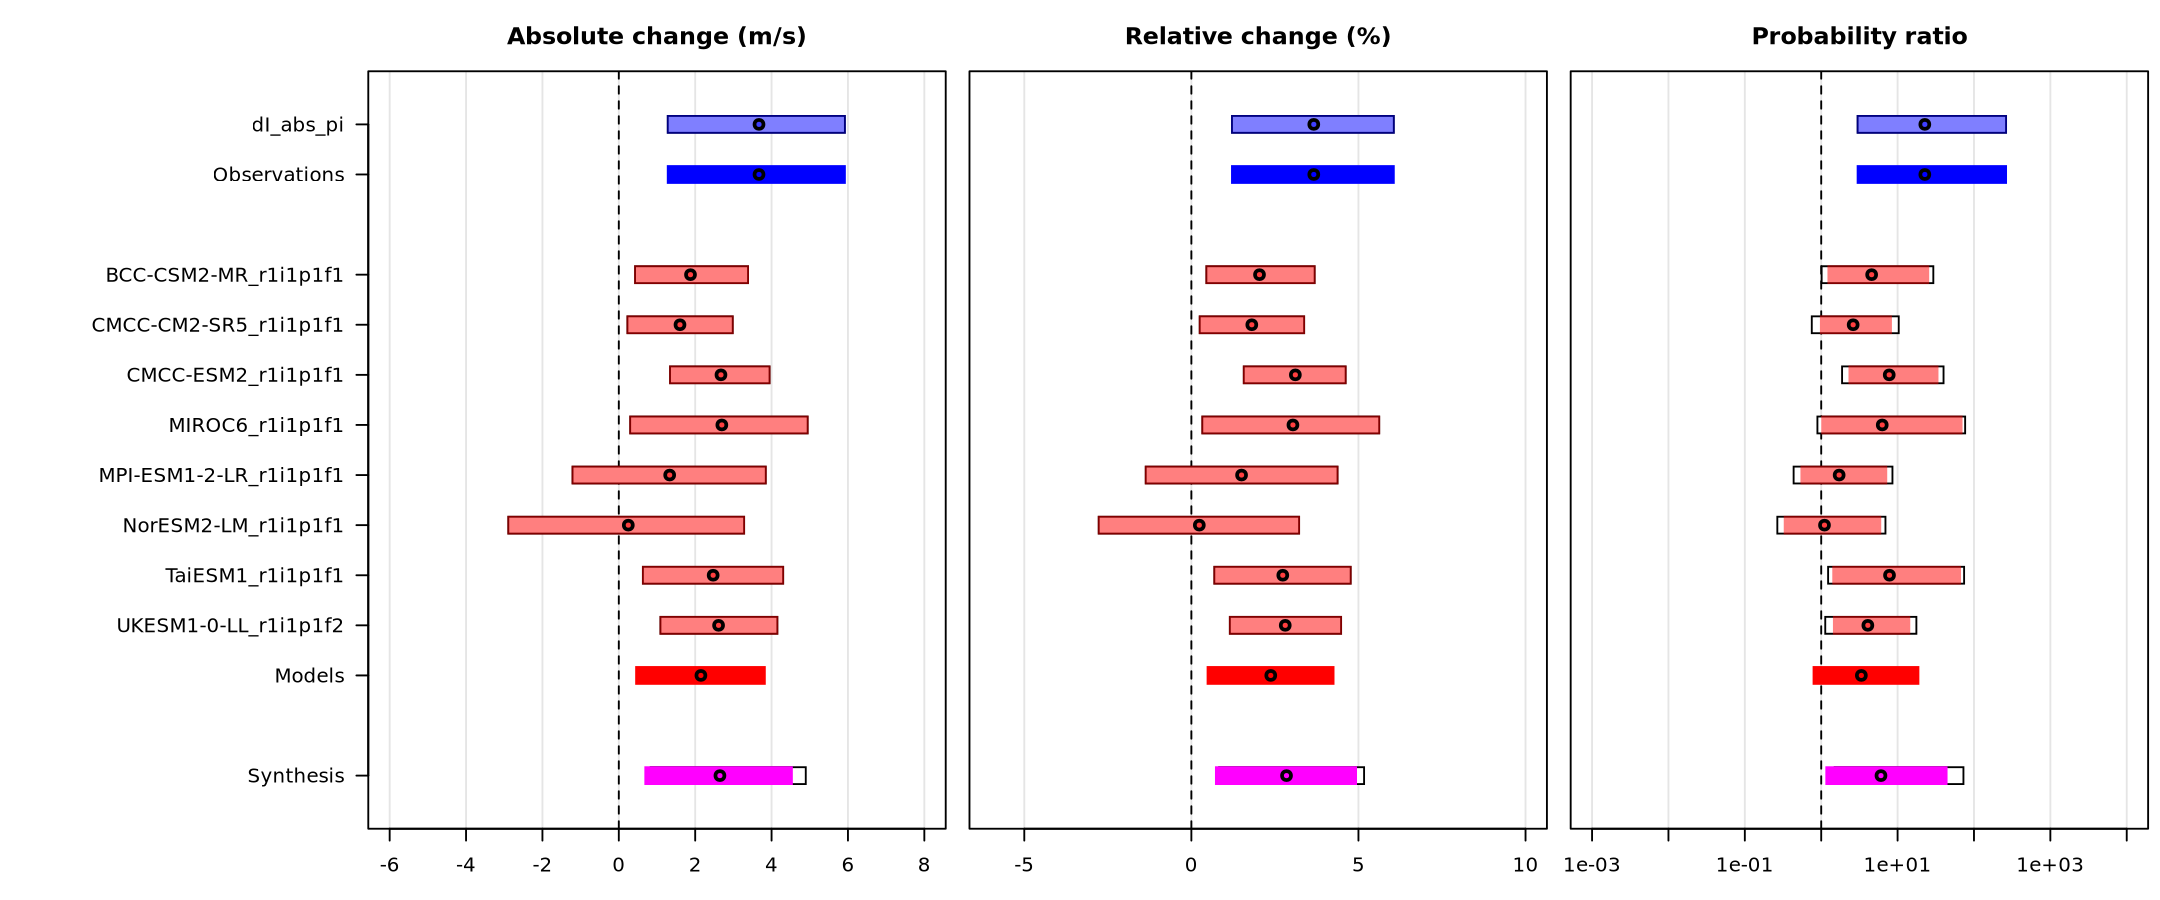

In [5]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synth_attr_abs, hide_labels = F, main = "Absolute change (m/s)", xlim = c(-6,8))
plot_synthesis(synth_attr_rel, hide_labels = T, main = "Relative change (%)", xlim = c(-6,10))
plot_synthesis(synth_attr_pr, hide_labels = T, main = "Probability ratio", xlim = c(1e-3, 1e4))

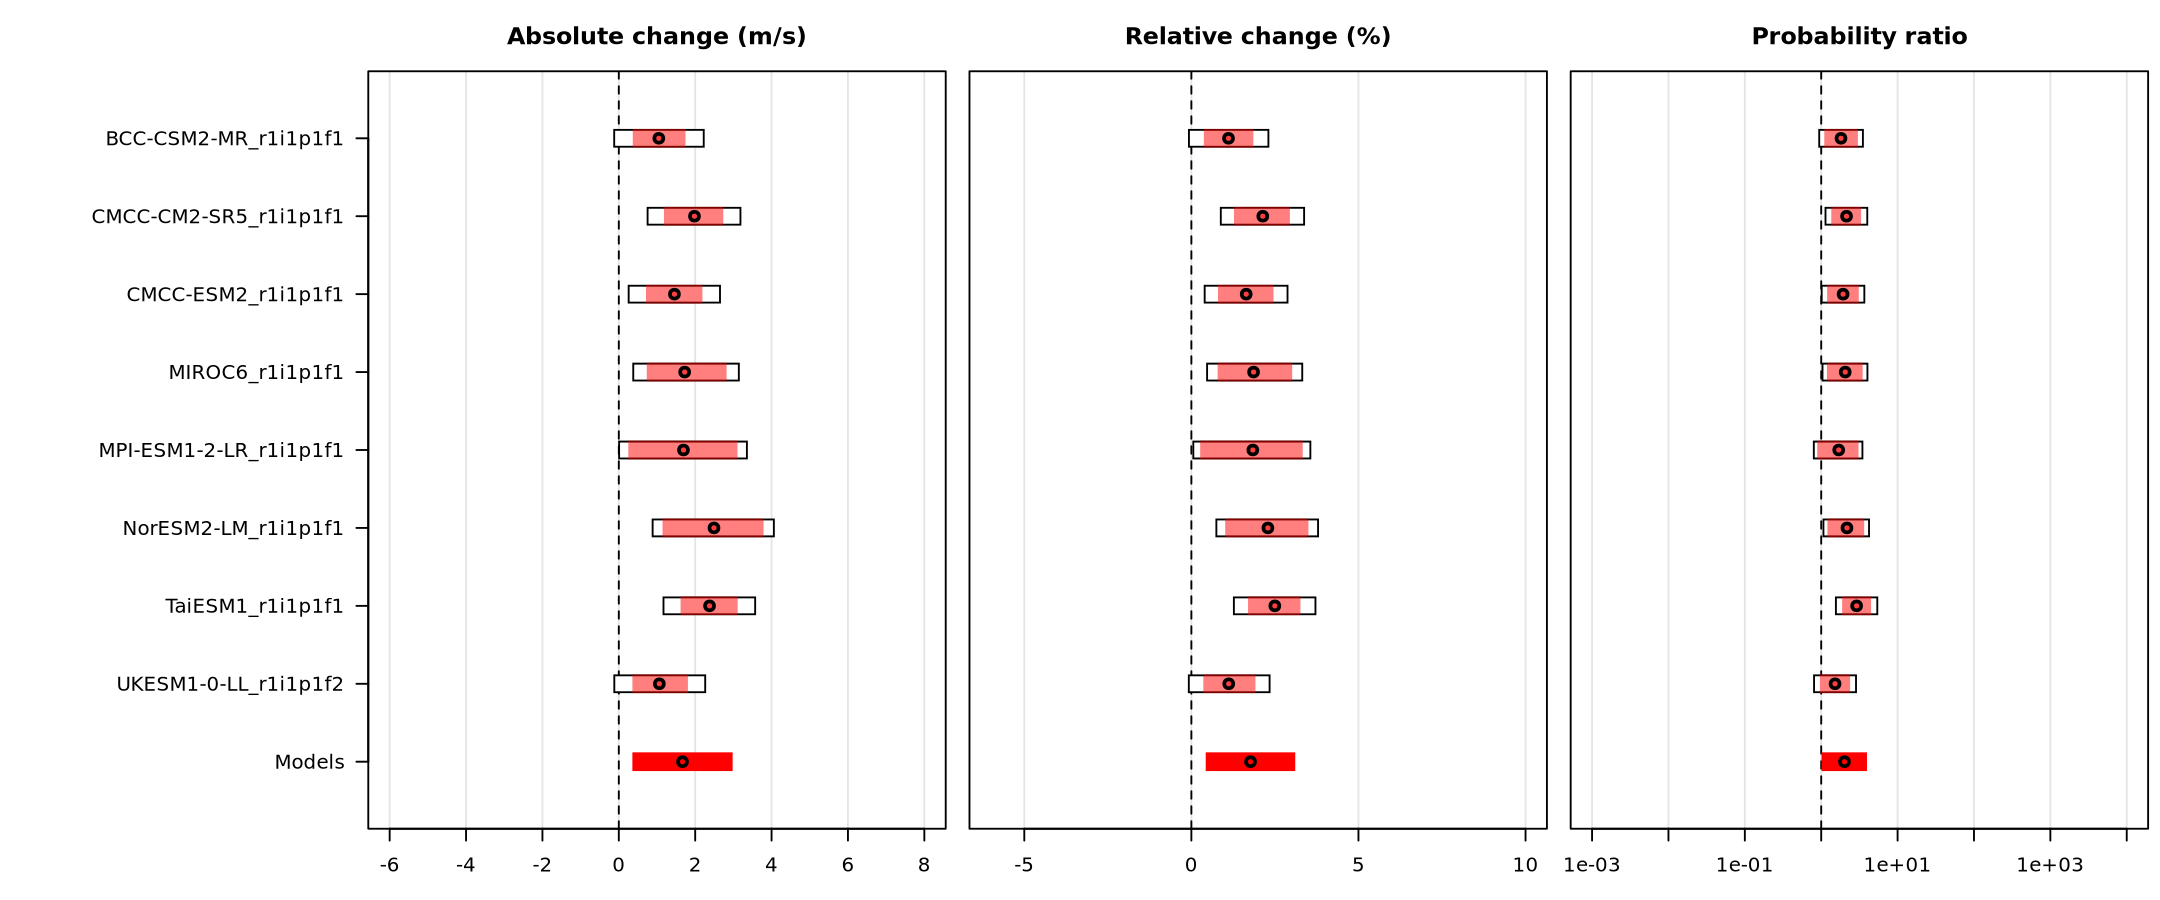

In [6]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.abs",colnames(res_mdl))],
                         synth_type = "abs"), hide_labels = F, main = "Absolute change (m/s)", xlim = c(-6,8))

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.rel",colnames(res_mdl))],
                         synth_type = "rel"), hide_labels = T, main = "Relative change (%)", xlim = c(-6,10))

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_PR",colnames(res_mdl))],
                         synth_type = "PR"), hide_labels = T, main = "Probability ratio", xlim = c(1e-3, 1e4))

### Synthesis figures for paper

In [7]:
res_mdl <- read.csv("res-models_pi_gmst+amo.csv", row.names = "X.1")
res_obs <- read.csv("res/res-obs_gmst+amo_pi_era5.csv", row.names = "X")

include <- read.csv("model-eval_gmst+amo.csv")
res_mdl <- res_mdl[include$model[include$include == "Y"],]

In [8]:
synth_attr_abs <- synthesis(obs_in = res_obs["dI_abs_pi",],
                            models_in = res_mdl[,grepl("attr_dI.abs",colnames(res_mdl))],
                            synth_type = "abs")
synth_attr_abs$df[1,2] <- "ERA5"

synth_attr_pr <- synthesis(obs_in = res_obs["PR_pi",],
                           models_in = res_mdl[,grepl("attr_PR",colnames(res_mdl))],
                           synth_type = "PR")
synth_attr_pr$df[1,2] <- "ERA5"

synth_proj_abs <- synthesis(obs_in = NA,
                            models_in = res_mdl[,grepl("proj_dI.abs",colnames(res_mdl))],
                            synth_type = "abs")

synth_proj_pr <- synthesis(obs_in = NA,
                           models_in = res_mdl[,grepl("proj_PR",colnames(res_mdl))],
                           synth_type = "PR")

In [9]:
res <- 240

png("fig/synthesis_pi_attr.png", h = res*1.5, w = res*5/6*3); {
    
    prep_window(c(1,2), mar = c(3,0.5,3,0.5), oma = c(0,13,0,1), h = 5, w = 4)

    plot_synthesis(synth_attr_pr, hide_labels = F, main = "", xlim = c(1e-3, 1e4))
    mtext("(a) Probability ratio", side = 3, font = 2, line = 1)
    
    plot_synthesis(synth_attr_abs, hide_labels = T, main = "", xlim = c(-6,8))
    mtext("(b) Change in intensity (m/s)", side = 3, font = 2, line = 1)
    
}; dev.off()

agg_record_1456384142 
                    2

In [10]:
res <- 240

png("fig/synthesis_pi_proj.png", h = res*1.5, w = res*5/6*3); {
    
    prep_window(c(1,2), mar = c(3,0.5,3,0.5), oma = c(0,13,0,1), h = 5, w = 4)

    plot_synthesis(synth_proj_pr, hide_labels = F, main = "", xlim = c(1e-1, 1e2))
    mtext("(a) Probability ratio", side = 3, font = 2, line = 1)
    
    plot_synthesis(synth_proj_abs, hide_labels = T, main = "", xlim = c(-2,6))
    mtext("(b) Change in intensity (m/s)", side = 3, font = 2, line = 1)

}; dev.off()

agg_record_2093001094 
                    2

### Summary figures

In [10]:
res <- 240

png("fig/minisynthesis_pi_attr.png", h = res*1.5, w = res*5/6*3); {
    
    prep_window(c(2,2), mar = c(3,0.5,3,0.5), oma = c(0,8,1,1), h = 2, w = 4)

    # plot_synthesis(synth_attr_pr, hide_labels = F, main = "", xlim = c(1e-3, 1e4))
    plot_synthesis(synth_attr_pr$df[grepl("synth", synth_attr_pr$df$group),], log = T, hide_labels = F, main = "", xlim = c(1e-1, 1e3))
    mtext("(a) Probability ratio\n(Past - present)", side = 3, font = 2, line = 1)

    plot_synthesis(synth_attr_abs$df[grepl("synth", synth_attr_abs$df$group),], hide_labels = T, main = "", xlim = c(-1,7))
    mtext("(b) Change in intensity (m/s)\n(Past - present)", side = 3, font = 2, line = 1)

    plot_synthesis(synth_proj_pr$df[grepl("synth", synth_proj_pr$df$group),], log = T, hide_labels = F, main = "", xlim = c(1e-1, 1e3))
    mtext("(c) Probability ratio\n(Present - future)", side = 3, font = 2, line = 1)

    plot_synthesis(synth_proj_abs$df[grepl("synth", synth_proj_abs$df$group),], hide_labels = T, main = "", xlim = c(-1,7))
    mtext("(d) Change in intensity (m/s)\n(Present - future)", side = 3, font = 2, line = 1)
    
}; dev.off()

agg_record_2118151327 
                    2

### Theo summary figures

In [12]:
rnm <- "jamaica"

synth_attr_abs <- read.csv(paste0("synth/",rnm,"_attr_dI.rel.csv"), row.names = "X")
synth_attr_pr <- read.csv(paste0("synth/",rnm,"_attr_pr.csv"), row.names = "X")
synth_proj_abs <- read.csv(paste0("synth/",rnm,"_proj_dI.rel.csv"), row.names = "X")
synth_proj_pr <- read.csv(paste0("synth/",rnm,"_proj_pr.csv"), row.names = "X")

# if ( rnm == "cuba" ) {
#     # manually replace infinite values with the numbers from the report
#     synth_attr_pr[3,5] <- 4650
#     synth_attr_pr[25,5] <- 4.74
# }

uw <- list("jamaica" = c(1.43, 15.0), "cuba" = c(2.85, 23.2))[[rnm]]

png(paste0("fig/minisynthesis_pr-",rnm,".png"), h = res*1.5, w = res*5/6*3); {
    
    prep_window(c(2,2), mar = c(3,0.5,3,1), oma = c(0,8,1,0), h = 2, w = 4)
    
    xlim_pr <- list("jamaica" = c(1e-2, 1e2), "cuba" = c(1e-2, 1e2))[[rnm]]
    xlim_di <- list("jamaica" = c(-50,175), "cuba" = c(-50,175))[[rnm]]

    # plot_synthesis(synth_attr_pr, hide_labels = F, main = "", xlim = c(1e-3, 1e4))
    plot_synthesis(synth_attr_pr[grepl("synth", synth_attr_pr$group),], log = T, hide_labels = F, main = "", xlim = xlim_pr)
    mtext("(a) Probability ratio\n(Past - present)", side = 3, font = 2, line = 1)
    points(uw[1], 1, pch = 18, cex = 1.5)


    plot_synthesis(synth_attr_abs[grepl("synth", synth_attr_abs$group),], hide_labels = T, main = "", xlim = xlim_di)
    mtext("(b) Change in intensity (m/s)\n(Past - present)", side = 3, font = 2, line = 1)
    points(uw[2], 1, pch = 18, cex = 1.5)
    

    plot_synthesis(synth_proj_pr[grepl("synth", synth_proj_pr$group),], log = T, hide_labels = F, main = "", xlim = xlim_pr)
    mtext("(c) Probability ratio\n(Present - future)", side = 3, font = 2, line = 1)

    plot_synthesis(synth_proj_abs[grepl("synth", synth_proj_abs$group),], hide_labels = T, main = "", xlim = xlim_di)
    mtext("(d) Change in intensity (m/s)\n(Present - future)", side = 3, font = 2, line = 1)
    
}; dev.off()

agg_record_1292996303 
                    2

# GMST + standardised AMO

## Trend estimation

In [24]:
# standardise observed Nino to have mean 0 and sd 1 over 1979-2023
amo_obs <- load_ts("ts/hurricane-melissa_amo-sm10_ersst.dat", col.names = c("year", "amo"))

amo_1979 <- amo_obs$amo[amo_obs$year >= 1979]
amo_std <- data.frame("year" = amo_obs$year, "amo" = (amo_obs$amo - mean(amo_1979)) / sd(amo_1979))

# use 2025 standardised Nino as covariate
amo_2025 <- amo_std$amo[amo_std$year == 2025]

In [49]:
rp <- 5
for (fnm in list.files("ts", pattern = "pi_cmip6", full.names = T)) {
    print(fnm)

    gcm <- gsub(".+cmip6_|.dat","",fnm)
                
    res_fnm <- gsub("ts/.+cmip6_", "res/res-cmip6_gmst+amo-std_pi_", gsub(".dat", ".csv", fnm))
    if (file.exists(res_fnm)) next
     
    gmst_fnm <- list.files("~/00_WWA_project_folder/live/data/cmip6-gmsts/2024/ssp585/", pattern = gcm, full.names = T)
    if(length(gmst_fnm) == 0) next

    amo_fnm <- list.files("ts", pattern = paste0("amo.+", gcm), full.names = T)
    if(length(amo_fnm) == 0) next

    # load all the data
    ts <- load_ts(fnm, col.names = c("year", "x"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    amo <- load_ts(amo_fnm, col.names = c("year", "amo"))
    df <- merge(merge(gmst, amo), ts)
    df <- df[df$year <= 2070,]

    # add standardised AMO covariate
    amo_clim <- df[(df$year >= 1979) & (df$year <= 2025), "amo",drop = F]
    df$amo_std <- (df$amo - mean(amo_clim$amo)) / sd(amo_clim$amo)
    
    df$x <- as.numeric(df$x)
    df <- df[!is.na(df$x),]
    if (nrow(df) < 75) { next }

    # pick up model to be fitted depending on variable
    mdl <- tryCatch({
            do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "amo_std"), lower = F)))
        }, error = function(cond) {
            return(NULL)
        })
    if (is.null(mdl)) { 
        mdl <- do.call(fit_ns, append(mdl_args, list("data" = df, "varnm" = "x", covnm = c("gmst", "amo_std"), lower = F, "method" = "Nelder-Mead")))
    }

    # use model's 2025 GMST & standardised AMO to define factual climate
    gmst_2025 <- df$gmst[df$year == 2025]
    cov_now <- data.frame(gmst = gmst_2025, amo_std = amo_2025)
    cov_hist <- rbind("pi" = data.frame("gmst" = gmst_2025 - 1.3, "amo_std" = amo_2025), 
                    "neut" = data.frame("gmst" = gmst_2025, "amo_std" = 0))
    cov_fut <- data.frame(gmst = gmst_2025 + 1.3, amo_std = amo_2025)

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                          y_now = 2025, y_start = 1950, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/res", "mdl-eval/rlplot", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub("dat", "", fnm)), legend_pos = "bottomright")
        }; dev.off()
    }
}

[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-CM2_r1i1p1f1.dat"
[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"
[1] "ts/hurricane-melissa_pi_cmip6_ACCESS-ESM1-5_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_BCC-CSM2-MR_r1i1p1f1.dat"
[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"
[1] "ts/hurricane-melissa_pi_cmip6_CAMS-CSM1-0_r1i1p1f1.dat"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5_r1i1p1f1.dat"
[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"
[1] "ts/hurricane-melissa_pi_cmip6_CanESM5-CanOE_r1i1p2f1.dat"
[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-CM2-SR5_r1i1p1f1.dat"
[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"
[1] "ts/hurricane-melissa_pi_cmip6_CMCC-ESM2_r1i1p1f1.dat"
[1] "cov_cf has more than one row: only first row

## Compile results

In [60]:
fl <- list.files("res", pattern = "cmip6_gmst\\+amo-std", full.names = T)

mdl_res <- rbind.fill(sapply(fl, function(fnm) {

    res <- read.csv(fnm)
    gcm <- gsub(".+pi_|.csv","",fnm)
    
    corr_fnm <- list.files("res", pattern = paste0("corr-cmip6.+",gcm), full.names = T)
    if (length(corr_fnm) == 0) {
        res_cor <- set.names(rep(NA, 6),
                             c('amo.sd_est','amo.sd_lower','amo.sd_upper','amo.corr_est','amo.corr_lower','amo.corr_upper'))
    } else {
        res_cor <- read.csv(corr_fnm)
    }
    cbind(res, res_cor)
}, simplify = F))
rownames(mdl_res) <- gsub(".+pi_|.csv","",fl)
write.csv(mdl_res, "res-models_pi_gmst+amo-std.csv")

## Synthesis

In [121]:
res_mdl <- read.csv("res-models_pi_gmst+amo-std.csv", row.names = "X.1")
res_obs <- read.csv("res/res-obs_gmst+amo_pi_era5.csv", row.names = "X")

include <- read.csv("model-eval_gmst+amo.csv")
res_mdl <- res_mdl[include$model[include$include == "Y"],]

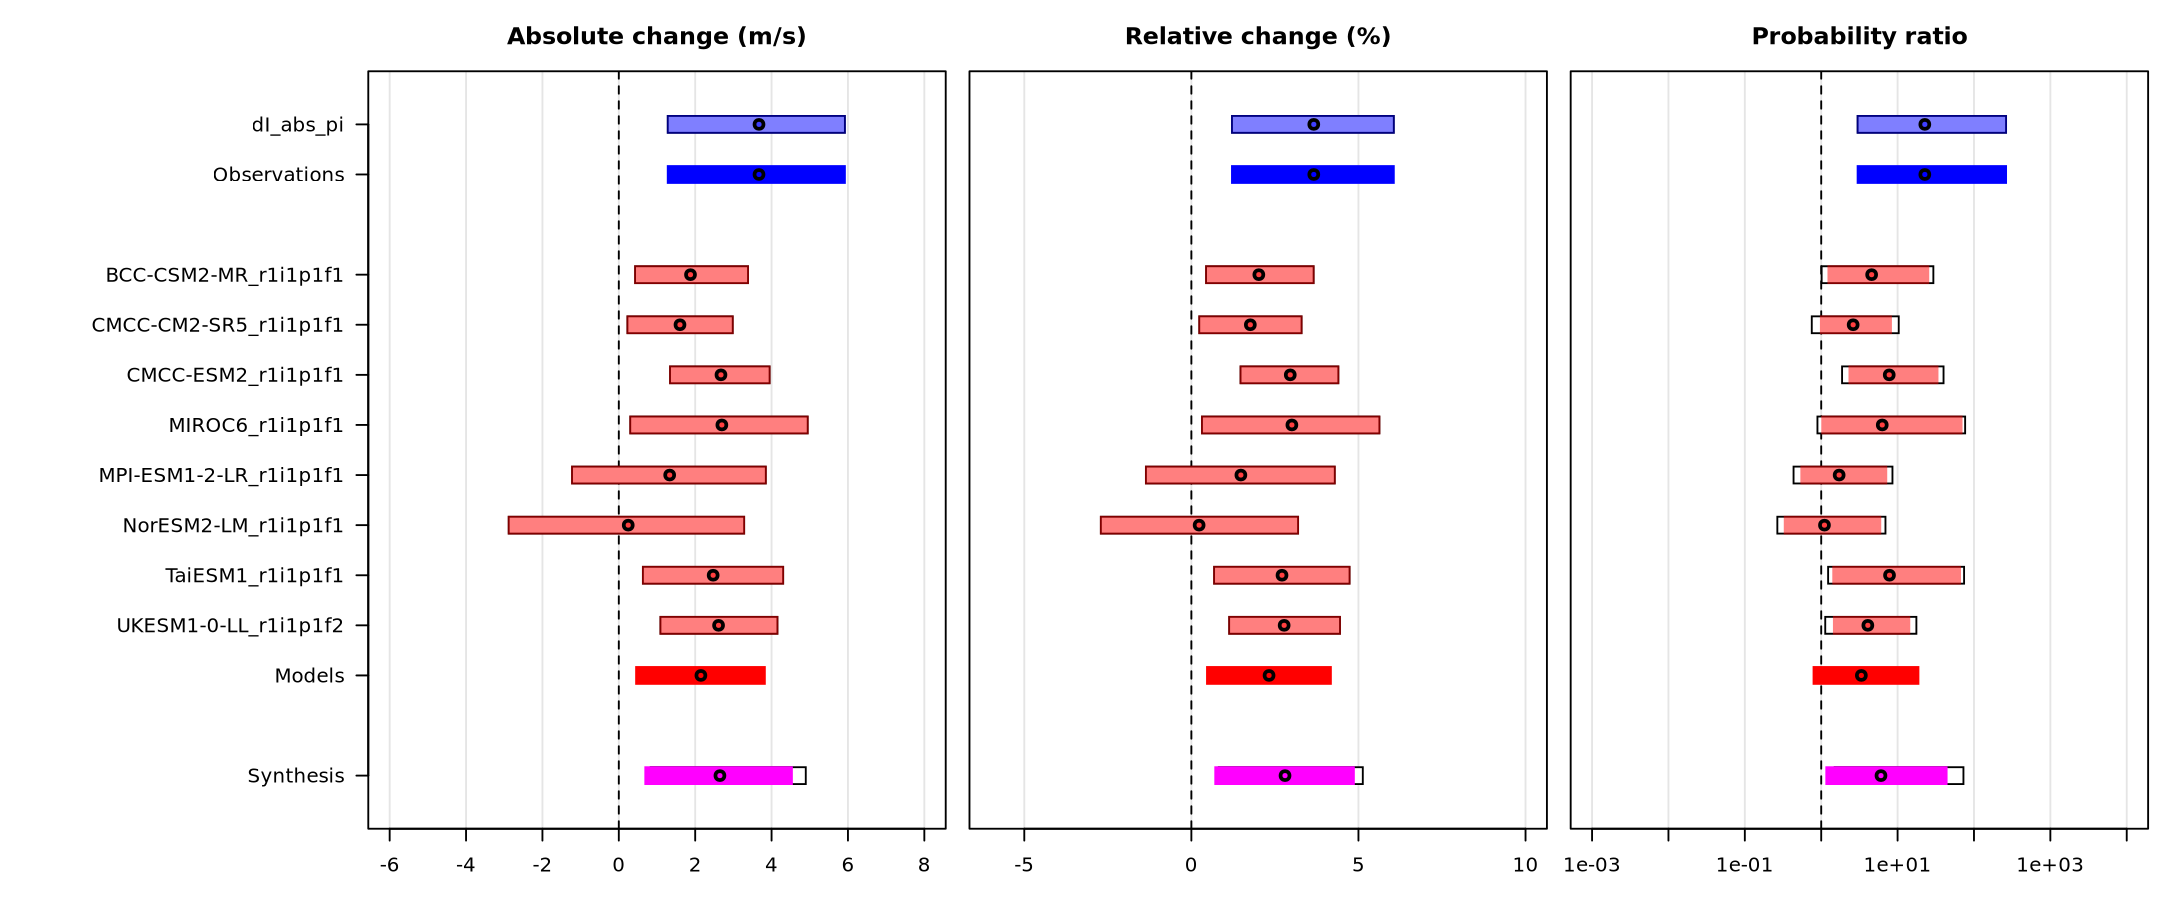

In [124]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synthesis(obs_in = res_obs["dI_abs_pi",],
                         models_in = res_mdl[,grepl("attr_dI.abs.pi",colnames(res_mdl))],
                         synth_type = "abs"), hide_labels = F, main = "Absolute change (m/s)", xlim = c(-6,8))

plot_synthesis(synthesis(obs_in = res_obs["dI_rel_pi",],
                         models_in = res_mdl[,grepl("attr_dI.rel.pi",colnames(res_mdl))],
                         synth_type = "rel"), hide_labels = T, main = "Relative change (%)", xlim = c(-6,10))

plot_synthesis(synthesis(obs_in = res_obs["PR_pi",],
                         models_in = res_mdl[,grepl("attr_PR.pi",colnames(res_mdl))],
                         synth_type = "PR"), hide_labels = T, main = "Probability ratio", xlim = c(1e-3, 1e4))

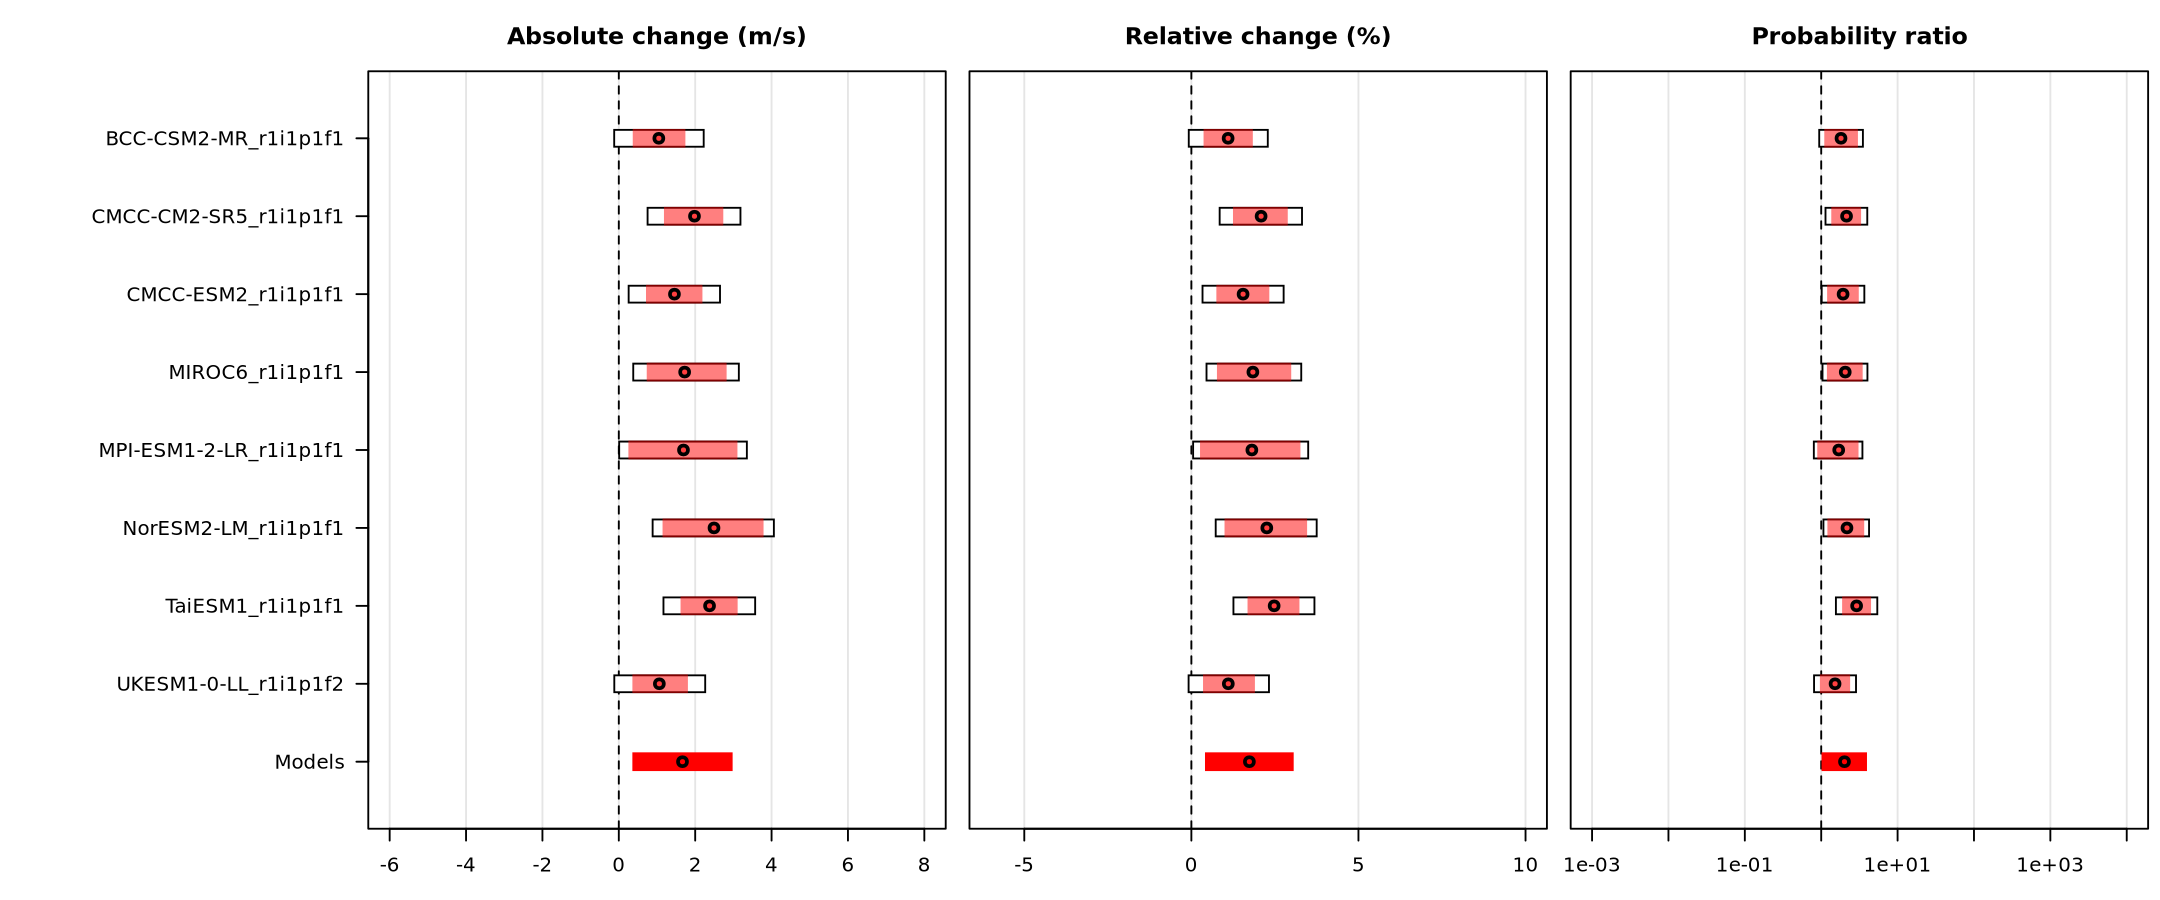

In [125]:
prep_window(c(1,3), mar = c(3,0.5,3,0.5), oma = c(0,15,0,0), res = 180, h = 5, w = 4)

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.abs",colnames(res_mdl))],
                         synth_type = "abs"), hide_labels = F, main = "Absolute change (m/s)", xlim = c(-6,8))

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.rel",colnames(res_mdl))],
                         synth_type = "rel"), hide_labels = T, main = "Relative change (%)", xlim = c(-6,10))

plot_synthesis(synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_PR",colnames(res_mdl))],
                         synth_type = "PR"), hide_labels = T, main = "Probability ratio", xlim = c(1e-3, 1e4))

In [2]:
synth_attr_abs <- (synthesis(obs_in = res_obs["dI_abs_pi",],
                         models_in = res_mdl[,grepl("attr_dI.abs.pi",colnames(res_mdl))],
                         synth_type = "abs"))

synth_attr_rel <- (synthesis(obs_in = res_obs["dI_rel_pi",],
                         models_in = res_mdl[,grepl("attr_dI.rel.pi",colnames(res_mdl))],
                         synth_type = "rel"))

synth_attr_pr <- (synthesis(obs_in = res_obs["PR_pi",],
                         models_in = res_mdl[,grepl("attr_PR.pi",colnames(res_mdl))],
                         synth_type = "PR"))

synth_proj_abs <- (synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.abs",colnames(res_mdl))],
                         synth_type = "abs"))

synth_proj_rel <- (synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_dI.rel",colnames(res_mdl))],
                         synth_type = "rel"))

synth_proj_pr <- (synthesis(obs_in = NA,
                         models_in = res_mdl[,grepl("proj_PR",colnames(res_mdl))],
                         synth_type = "PR"))

ERROR: Error in synthesis(obs_in = res_obs["dI_abs_pi", ], models_in = res_mdl[, : could not find function "synthesis"


In [127]:
for (synth_period in c("attr", "proj")) {
    for (synth_type in c("abs", "rel", "pr")) {
        synth <- get(paste0("synth_",synth_period,"_",synth_type))
        if (synth_period == "attr") { synth$df[1,2] <- "ERA5"}
        write.csv(rbind(synth$df,
                        setNames(c("unweighted", "Unweighted", synth$uw_mean, synth$df[nrow(synth$df),6:7], NA, NA),
                                 colnames(synth$df))),
                  paste0("synth/synth-pi_gmst+amo-std_gmst-effect_",synth_period,"_",synth_type,".csv"))
    }
}

In [1]:
synth_attr_abs

ERROR: Error: object 'synth_attr_abs' not found
